In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
# Path to the CSV file and image folder
csv_path = '/content/drive/My Drive/Thesis1/train.csv'
image_folder = '/content/drive/MyDrive/Thesis1/train'
# Load CSV data
data = pd.read_csv(csv_path)


In [ ]:
# Image dimensions
images = []
labels = []

In [ ]:
for index, row in data.iterrows():
    filename = row['Filename']
    label = row['Label']
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # EfficientNet uses RGB format
    img = img / 255.0  # Normalize pixel values to [0,1]
    images.append(img)
    labels.append(label)

X = np.array(images)
y = np.array(labels)

In [ ]:
print(X.shape)

(7560, 64, 64, 3)


In [ ]:
# Split data into training, validation, and test sets (70-15-15 split ratio)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
print(f"Number of images in X_train: {len(X_train)}")
print(f"Number of images in X_val: {len(X_val)}")
print(f"Number of images in X_test: {len(X_test)}")


Number of images in X_train: 5292
Number of images in X_val: 1134
Number of images in X_test: 1134


In [ ]:
# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Add GlobalAveragePooling2D layer and a Dense output layer for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)


In [ ]:
# Define the number of classes
num_classes = 4
# Modify the output layer to have 4 units for the 4 classes
predictions = Dense(num_classes, activation='softmax')(x)


In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


In [ ]:
datagen.fit(X_train)  # Assuming X_train contains your training images

In [ ]:
# Define the filepath where the model weights will be saved
checkpoint_filepath = '/content/drive/MyDrive/Thesis1_model.h5'


In [ ]:
# Create a ModelCheckpoint callback to save the model weights after each epoch
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train the model using the training and validation data, including the ModelCheckpoint callback
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint_callback])


Epoch 1/20
166/165 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.9208
Epoch 1: val_accuracy did not improve from 0.84744
165/165 [==============================] - 14s 82ms/step - loss: 0.2062 - accuracy: 0.9208 - val_loss: 1.3778 - val_accuracy: 0.6235
Epoch 2/20
166/165 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9312
Epoch 2: val_accuracy did not improve from 0.84744
165/165 [==============================] - 13s 79ms/step - loss: 0.1880 - accuracy: 0.9312 - val_loss: 1.1686 - val_accuracy: 0.7637
Epoch 3/20
166/165 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9339
Epoch 3: val_accuracy did not improve from 0.84744
165/165 [==============================] - 15s 90ms/step - loss: 0.1739 - accuracy: 0.9339 - val_loss: 1.5996 - val_accuracy: 0.4048
Epoch 4/20
166/165 [==============================] - ETA: 0s - loss: 0.1738 - accuracy: 0.9354
Epoch 4: val_accuracy did not improve from 0.84744
165/165 [====

In [ ]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:20]:
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train more layers
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
166/166 [==============================] - 47s 76ms/step - loss: 0.1692 - accuracy: 0.9331 - val_loss: 0.1333 - val_accuracy: 0.9453
Epoch 2/20
166/166 [==============================] - 9s 55ms/step - loss: 0.1625 - accuracy: 0.9384 - val_loss: 0.1318 - val_accuracy: 0.9480
Epoch 3/20
166/166 [==============================] - 11s 67ms/step - loss: 0.1565 - accuracy: 0.9414 - val_loss: 0.1312 - val_accuracy: 0.9489
Epoch 4/20
166/166 [==============================] - 10s 61ms/step - loss: 0.1489 - accuracy: 0.9452 - val_loss: 0.1301 - val_accuracy: 0.9480
Epoch 5/20
166/166 [==============================] - 10s 59ms/step - loss: 0.1514 - accuracy: 0.9460 - val_loss: 0.1309 - val_accuracy: 0.9497
Epoch 6/20
166/166 [==============================] - 11s 66ms/step - loss: 0.1506 - accuracy: 0.9431 - val_loss: 0.1307 - val_accuracy: 0.9480
Epoch 7/20
166/166 [==============================] - 9s 56ms/step - loss: 0.1577 - accuracy: 0.9439 - val_loss: 0.1301 - val_accuracy: 0

In [ ]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:20]:
    layer.trainable = True

# Recompile the model with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.000001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train more layers
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
166/166 [==============================] - 46s 62ms/step - loss: 0.0694 - accuracy: 0.9754 - val_loss: 0.4519 - val_accuracy: 0.8995
Epoch 2/20
166/166 [==============================] - 10s 62ms/step - loss: 0.0709 - accuracy: 0.9728 - val_loss: 0.0885 - val_accuracy: 0.9630
Epoch 3/20
166/166 [==============================] - 9s 52ms/step - loss: 0.0651 - accuracy: 0.9766 - val_loss: 0.0805 - val_accuracy: 0.9674
Epoch 4/20
166/166 [==============================] - 9s 57ms/step - loss: 0.0637 - accuracy: 0.9766 - val_loss: 0.0809 - val_accuracy: 0.9691
Epoch 5/20
166/166 [==============================] - 10s 58ms/step - loss: 0.0677 - accuracy: 0.9739 - val_loss: 0.0797 - val_accuracy: 0.9700
Epoch 6/20
166/166 [==============================] - 8s 51ms/step - loss: 0.0581 - accuracy: 0.9800 - val_loss: 0.0780 - val_accuracy: 0.9709
Epoch 7/20
166/166 [==============================] - 10s 59ms/step - loss: 0.0600 - accuracy: 0.9781 - val_loss: 0.0778 - val_accuracy: 0.

In [ ]:
# Save the entire model in the native Keras format
model.save('/content/drive/MyDrive/Thesis1_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from the native Keras format
loaded_model = load_model('/content/drive/MyDrive/Thesis1_model.keras')

In [ ]:
# Values you provided for 20 epochs
epochs = list(range(1, 21))
train_loss = [0.1692, 0.1625, 0.1565, 0.1489, 0.1514, 0.1506, 0.1577, 0.1600, 0.1518, 0.1609,
              0.1488, 0.1485, 0.1437, 0.1425, 0.1504, 0.1460, 0.1498, 0.1411, 0.1481, 0.1430]

valid_loss = [0.1333, 0.1318, 0.1312, 0.1301, 0.1309, 0.1307, 0.1301, 0.1291, 0.1286, 0.1289,
              0.1285, 0.1285, 0.1286, 0.1278, 0.1266, 0.1257, 0.1255, 0.1256, 0.1260, 0.1247]

train_accuracy = [0.9331, 0.9384, 0.9414, 0.9452, 0.9460, 0.9431, 0.9439, 0.9405, 0.9418, 0.9395,
                   0.9456, 0.9443, 0.9460, 0.9469, 0.9416, 0.9461, 0.9427, 0.9484, 0.9437, 0.9509]

valid_accuracy = [0.9453, 0.9480, 0.9489, 0.9480, 0.9497, 0.9480, 0.9471, 0.9480, 0.9489, 0.9497,
                   0.9480, 0.9480, 0.9515, 0.9506, 0.9497, 0.9506, 0.9480, 0.9497, 0.9489, 0.9515]

# Print lengths of the lists
print("Length of epochs:", len(epochs))
print("Length of train_loss:", len(train_loss))
print("Length of valid_loss:", len(valid_loss))
print("Length of train_accuracy:", len(train_accuracy))
print("Length of valid_accuracy:", len(valid_accuracy))


Length of epochs: 20
Length of train_loss: 20
Length of valid_loss: 20
Length of train_accuracy: 20
Length of valid_accuracy: 20


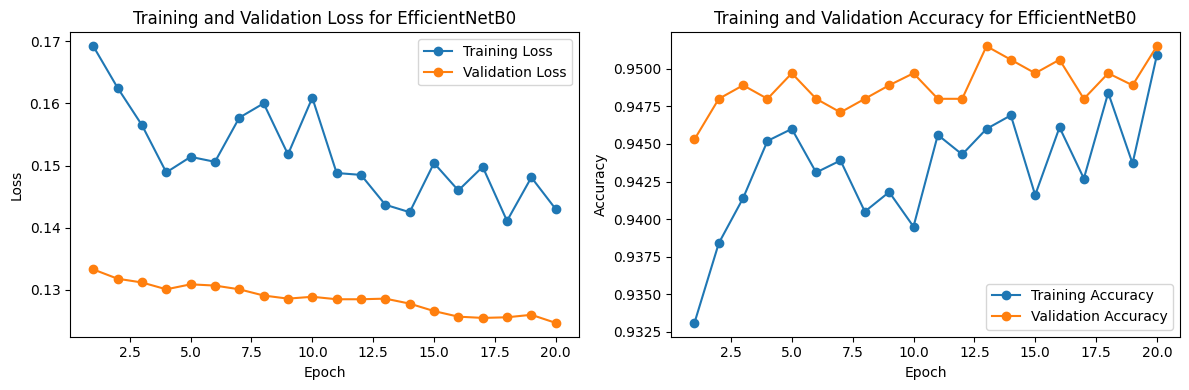

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, valid_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for EfficientNetB0')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, valid_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for EfficientNetB0')
plt.legend()

plt.tight_layout()
plt.show()


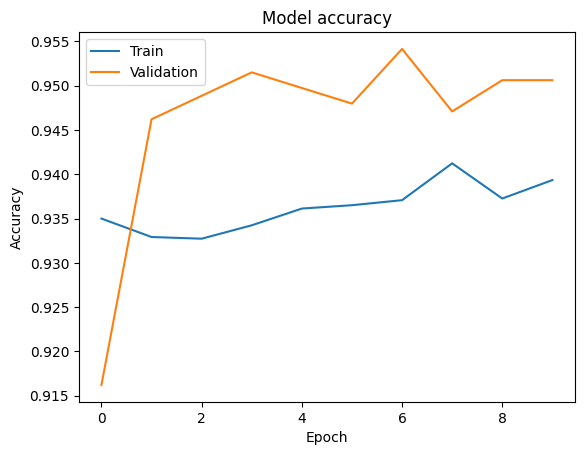

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')



36/36 [==============================] - 1s 15ms/step - loss: 0.0635 - accuracy: 0.9744
Test Loss: 0.06351342797279358, Test Accuracy: 0.974426805973053


In [ ]:
# Make predictions on the test data
predictions = model.predict(X_test)


36/36 [==============================] - 1s 16ms/step


In [ ]:
# Convert predicted labels to class indices
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
# Map class indices to cell types
class_labels = {
    0: "Normal epithelial cell nuclei",
    1: "Cancer epithelial cell nuclei",
    2: "Muscle cell nuclei",
    3: "Immune leukocyte cell nuclei"
}

In [ ]:
# Assuming your original data has a 'Filename' column
image_filenames = data['Filename'].tolist()

In [ ]:
# Loop through the test data and print image name, true label, and predicted label
for i in range(len(predicted_labels)):
    image_name = image_filenames[i]  # Get the image name corresponding to the current index
    true_label = class_labels[y_test[i]]  # Get the true label for the current index
    predicted_label = class_labels[predicted_labels[i]]  # Get the predicted label for the current index
    print(f"Image Name: {image_name}, True Label: {true_label}, Predicted Label: {predicted_label}")

Image Name: 1.png, True Label: Immune leukocyte cell nuclei, Predicted Label: Immune leukocyte cell nuclei
Image Name: 2.png, True Label: Immune leukocyte cell nuclei, Predicted Label: Immune leukocyte cell nuclei
Image Name: 3.png, True Label: Immune leukocyte cell nuclei, Predicted Label: Immune leukocyte cell nuclei
Image Name: 4.png, True Label: Cancer epithelial cell nuclei, Predicted Label: Cancer epithelial cell nuclei
Image Name: 5.png, True Label: Cancer epithelial cell nuclei, Predicted Label: Cancer epithelial cell nuclei
Image Name: 6.png, True Label: Immune leukocyte cell nuclei, Predicted Label: Immune leukocyte cell nuclei
Image Name: 7.png, True Label: Immune leukocyte cell nuclei, Predicted Label: Immune leukocyte cell nuclei
Image Name: 8.png, True Label: Cancer epithelial cell nuclei, Predicted Label: Cancer epithelial cell nuclei
Image Name: 9.png, True Label: Muscle cell nuclei, Predicted Label: Muscle cell nuclei
Image Name: 10.png, True Label: Cancer epithelial c

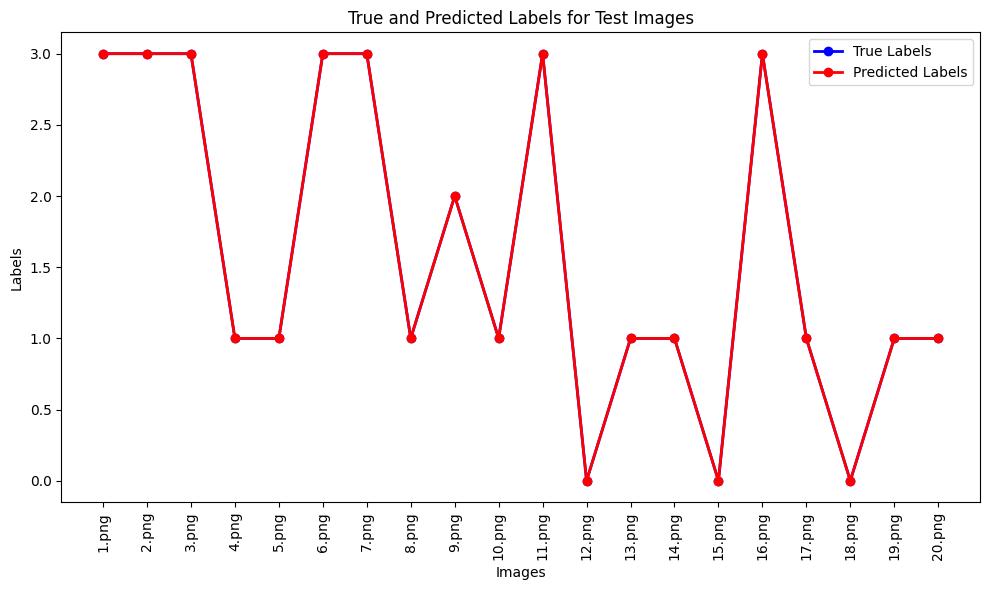

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Limit the number of displayed labels for better visualization
max_display_labels = 20

# Assuming your original data has a 'Filename' column
image_filenames = data['Filename'].tolist()[:max_display_labels]  # Limit the number of displayed labels
x_positions = np.arange(len(image_filenames))

# Create a line graph for visualization
plt.figure(figsize=(10, 6))

# Plot true labels in blue
plt.plot(x_positions, y_test[:max_display_labels], marker='o', color='b', label='True Labels', linewidth=2)

# Plot predicted labels in red
plt.plot(x_positions, predicted_labels[:max_display_labels], marker='o', color='r', label='Predicted Labels', linewidth=2)

# Customize the plot
plt.xticks(x_positions, image_filenames, rotation='vertical')  # Use image names as x-tick labels with vertical rotation
plt.xlabel('Images')
plt.ylabel('Labels')
plt.title('True and Predicted Labels for Test Images')
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


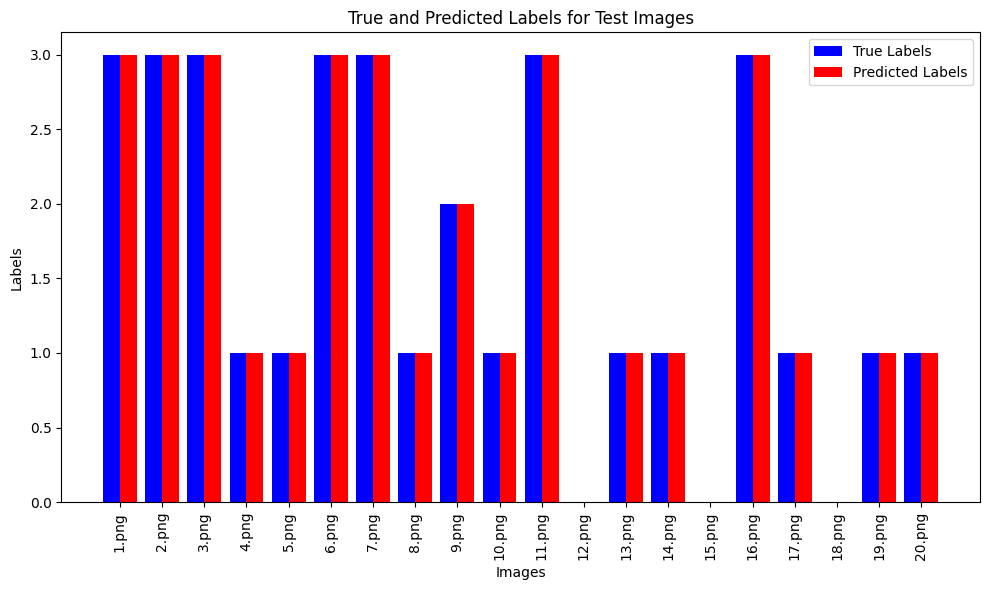

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Limit the number of displayed labels for better visualization
max_display_labels = 20

# Assuming your original data has a 'Filename' column
image_filenames = data['Filename'].tolist()[:max_display_labels]  # Limit the number of displayed labels
x_positions = np.arange(len(image_filenames))

# Create a bar chart
plt.figure(figsize=(10, 6))

# Plot true labels in blue
true_labels = y_test[:max_display_labels]
plt.bar(x_positions - 0.2, true_labels, width=0.4, label='True Labels', color='blue')

# Plot predicted labels in red
predicted_labels = predicted_labels[:max_display_labels]  # Make sure they have the same length
x_positions_pred = x_positions[:len(predicted_labels)]  # Adjust x_positions to match the length
plt.bar(x_positions_pred + 0.2, predicted_labels, width=0.4, label='Predicted Labels', color='red')

# Customize the plot
plt.xticks(x_positions, image_filenames, rotation='vertical')  # Use image names as x-tick labels with vertical rotation
plt.xlabel('Images')
plt.ylabel('Labels')
plt.title('True and Predicted Labels for Test Images')
plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
print(y_test.shape)
print(predicted_labels.shape)

(1134,)
(1134,)


In [ ]:
precision = precision_score(y_test, predicted_labels, average='weighted')
print(f'Precision: {precision:.2f}')

Precision: 0.97


In [ ]:
recall = recall_score(y_test, predicted_labels, average='weighted')
print(f'Recall: {recall:.2f}')

Recall: 0.97


In [ ]:
f1 = f1_score(y_test, predicted_labels, average='weighted')
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.97


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Assuming you have a function to load and preprocess test images
def load_and_preprocess_test_images(test_folder_path):
    images = []
    for filename in os.listdir(test_folder_path):
        img_path = os.path.join(test_folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Resize to match the model's input size
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # EfficientNet uses RGB format
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Update this with the path to the folder containing your new test images
new_test_folder_path = '/content/drive/MyDrive/Thesis1/test'

# Load and preprocess new test images
new_test_images = load_and_preprocess_test_images(new_test_folder_path)

# Load the trained model
model = load_model('/content/drive/MyDrive/Thesis1.h5')  # Update with your actual model path

# Make predictions for the new test images
new_predictions = model.predict(new_test_images)

# Convert predictions to class labels (0, 1, 2, 3)
new_predicted_labels = np.argmax(new_predictions, axis=1)

# Map predicted labels to cell types
class_labels = {
    0: "Normal epithelial cell nuclei",
    1: "Cancer epithelial cell nuclei",
    2: "Muscle cell nuclei",
    3: "Immune leukocyte cell nuclei"
}

# Map predicted labels to cell types for the new test images
new_predicted_cell_types = [class_labels[label] for label in new_predicted_labels]

# Print the predicted cell types for each new test image
for i, cell_type in enumerate(new_predicted_cell_types):
    print(f"New Test Image {i + 1}: Predicted Cell Type - {cell_type}")


Streaming output truncated to the last 5000 lines.
New Test Image 42: Predicted Cell Type - Muscle cell nuclei
New Test Image 43: Predicted Cell Type - Immune leukocyte cell nuclei
New Test Image 44: Predicted Cell Type - Muscle cell nuclei
New Test Image 45: Predicted Cell Type - Muscle cell nuclei
New Test Image 46: Predicted Cell Type - Muscle cell nuclei
New Test Image 47: Predicted Cell Type - Muscle cell nuclei
New Test Image 48: Predicted Cell Type - Muscle cell nuclei
New Test Image 49: Predicted Cell Type - Muscle cell nuclei
New Test Image 50: Predicted Cell Type - Muscle cell nuclei
New Test Image 51: Predicted Cell Type - Muscle cell nuclei
New Test Image 52: Predicted Cell Type - Muscle cell nuclei
New Test Image 53: Predicted Cell Type - Muscle cell nuclei
New Test Image 54: Predicted Cell Type - Muscle cell nuclei
New Test Image 55: Predicted Cell Type - Immune leukocyte cell nuclei
New Test Image 56: Predicted Cell Type - Muscle cell nuclei
New Test Image 57: Predicted 

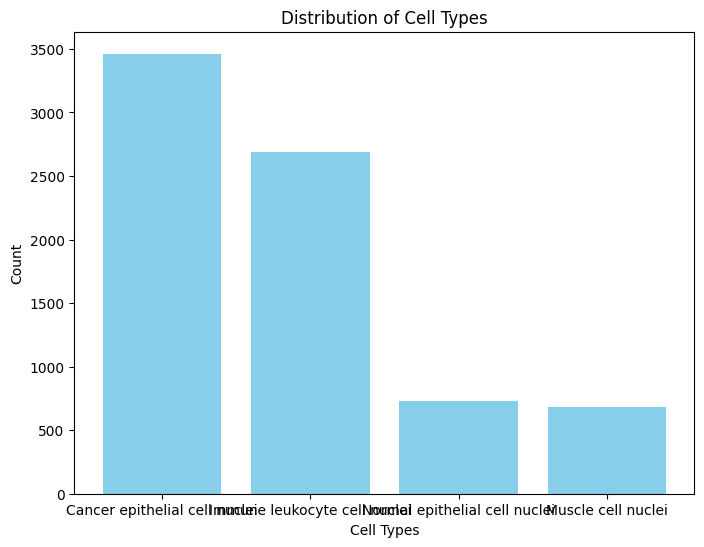

In [ ]:
# Assuming you have a pandas DataFrame named 'data' with a column 'Label' representing class labels
class_counts = data['Label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar([class_labels[label] for label in class_counts.index], class_counts.values, color='skyblue')
plt.xlabel('Cell Types')
plt.ylabel('Count')
plt.title('Distribution of Cell Types')
plt.show()


[[122   1   0   3]
 [  2 505   1   1]
 [  0   1 100   7]
 [  4   4   5 378]]


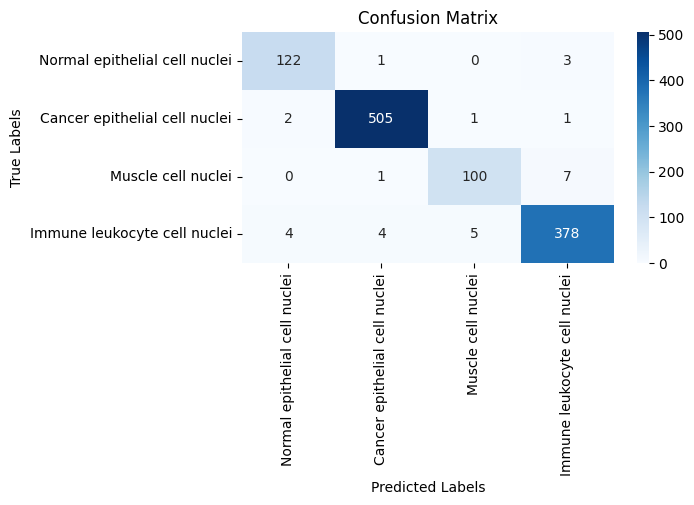

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
print(conf_matrix)

# Create a heatmap for visualization
plt.figure(figsize=(6, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=class_labels.values(),
            yticklabels=class_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()